<a href="https://colab.research.google.com/github/ericmuckley/code/blob/master/milk_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries that we need

In [0]:
# for importing / exporting files and creating DataFrames (tables)
import pandas as pd
# for dealing with multi-dimensional arrays
import numpy as np
# for smoothing and fitting spectra
from scipy import signal
from scipy.interpolate import splrep
from scipy.interpolate import splev
# for creating interactive plots
import itertools 
import bokeh
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.palettes import Dark2_8 as palette

### Create custom functions for making interactive plots using Bokeh

In [0]:
def setup_fig(title='Title', xlabel='X', ylabel='Y', fontsize=12):
    """
    Create interactive Bokeh plot.
    """
    # create the figure
    p = figure(width=600, height=400,
               title=title,
               x_axis_label=xlabel,
               y_axis_label=ylabel,
               tools="pan,wheel_zoom,box_zoom,reset")
    # adjust properties of the figure to make it look good
    p.toolbar.logo = None
    fs = str(int(fontsize))+'pt'
    p.title.text_font_size = fs
    p.xaxis.axis_label_text_font_size = fs
    p.yaxis.axis_label_text_font_size = fs
    p.xaxis.major_label_text_font_size = fs
    p.yaxis.major_label_text_font_size = fs
    p.xaxis.axis_label_text_font_style = "normal"
    p.yaxis.axis_label_text_font_style = "normal"
    return p

def plot_line(df, title='Title', xlabel='X', ylabel='Y', fontsize=12):
    """
    Create interactive Bokeh line plot. Input df should be Pandas Dataframe,
    where the first column is x-values and following columns are y-values.
    """
    p = setup_fig(title=title, xlabel=xlabel, ylabel=ylabel, fontsize=fontsize)
    colors = itertools.cycle(palette)
    # loop over each column in the data and add to plot
    for col, color in zip(range(1, len(df.columns)), colors):
        p.line(df[df.columns[0]],
               df[df.columns[col]],
               line_color=color,
               line_width=4, legend=df.columns[col], alpha=0.6,
               muted_color=color, muted_alpha=0.2)
    p.legend.click_policy = "mute"
    # show the plot after this function using show(p)
    output_notebook()
    return p

### Import data files from Github and plot raw data

In [3]:
# list of files to import
file_list = ['milk__FTIR.csv', 'milk__RAMAN.csv', 'milk__UVVIS.csv']

# Github URL where files are being stored
url = 'https://raw.githubusercontent.com/ericmuckley/datasets/master/'

# create empty dictionary to hold raw dataframes
raw_dfs = {}

# loop over each file to import it
for filename in file_list:

    # read the file from the URL as a csv file into a Pandas DataFrame
    df = pd.read_csv(url + filename)

    # sort low to high by wavenumber. this is required for spline smoothing
    df.sort_values(by=df.columns[0], inplace=True)

    # get the measurement type from the filename
    measurement_type = filename.split('__')[1].split('.csv')[0].lower()

    # save the dataframe to the dictionary
    raw_dfs[measurement_type] = df

    # display information about each file and plot all spectra
    print('\n\n------------- ' + measurement_type.upper() + ' --------------')
    print('rows: %i, columns: %i' %(df.shape[0], df.shape[1]))
    # show the first few rows of the file
    print(df.head())
    #plot the data using our custom plot_line function
    p = plot_line(df, title=measurement_type.upper(),
                  xlabel=df.columns[0], ylabel='Intensity')
    show(p)



------------- FTIR --------------
rows: 1867, columns: 7
              w     day1     day2     day3     day4     day5     day6
1866  399.20229  0.24052  0.26080  0.24382  0.26968  0.31730  0.27146
1865  401.13080  0.24032  0.26042  0.24278  0.27428  0.32127  0.26916
1864  403.05932  0.23823  0.25808  0.24205  0.27714  0.32322  0.26622
1863  404.98783  0.23838  0.25581  0.24218  0.27599  0.32274  0.26462
1862  406.91634  0.24189  0.25584  0.24291  0.27213  0.32054  0.26472




------------- RAMAN --------------
rows: 5220, columns: 7
               w         day1  ...         day5         day6
5219   99.417503  1956.272949  ...  2055.408447  2694.281250
5218  100.552315  2027.160278  ...  2216.655518  2672.766602
5217  101.686905  2009.920288  ...  2256.752686  2838.571777
5216  102.821281  2096.275146  ...  2418.100586  2975.784668
5215  103.955437  2178.253662  ...  2400.929199  2980.768066

[5 rows x 7 columns]




------------- UVVIS --------------
rows: 1801, columns: 7
        w      day1      day2      day3      day4      day5      day6
1800  200  1.525290  1.411493  1.225504  1.455335  1.944736  1.246034
1799  201  1.596420  1.367719  1.194246  1.530849  1.980900  1.211463
1798  202  1.604842  1.398759  1.259107  1.421070  2.039033  1.289129
1797  203  1.612978  1.320230  1.138830  1.410097  1.978017  1.115122
1796  204  1.595931  1.239846  1.121634  1.387371  1.907074  1.261404


### Resample and normalize each spectrum
To use multiple spectra as inputs for a model,
the number of points in each type of spectrum should be the same.

Here we fit each spectrum to a spline and resample it into
a specified number of points **new_length**. Then we plot the original data
and the new resampled spectra to make sure that the resampling did not
change the shape of the spectrum.

For using the spectra in PCA or machine learning models, they should be
normalized first. The easiest way to do this is subtract each spectrum
by its minimum value and divide by the maximum value, so the min-max
scale goes from 0-1. This is done by the **normalize_df** function.

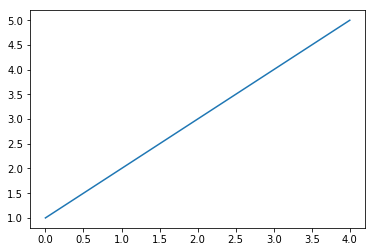

In [28]:
import matplotlib.pyplot as plt

plt.plot([1,2,3,4,5])
plt.show()

In [4]:
def arr_resample(arr, new_len=100, new_xlims=None, vec_scale='lin', k=3, s=0):
    '''
    Resamples (stetches/compresses) a 2D array by using a spline fit.
    Array should be shape [[x1, y1, ...ym], ...[xn, yn, ...yn]] where the
    # first column in array is x-values and following next columns are
    y values. If no x values exist, insert column np.arange(len(arr))
    as x values.
    Accepts linear or log x-values, and new x_limits.
    k and s are degree and smoothing factor of the interpolation spline.
    '''
    # first, check whether array should be resampled using
    # a linear or log scale:
    if vec_scale == 'lin':
        new_scale = np.linspace
    if vec_scale == 'log':
        new_scale = np.geomspace
    # get new x-limits for the resampled array
    if new_xlims is None:
        new_x1, new_x2 = arr[0, 0], arr[-1, 0]
    else:
        new_x1, new_x2 = new_xlims[0], new_xlims[1]
    # create new x values
    arrx = new_scale(new_x1, new_x2, new_len)
    # create new empty array to hold resampled values
    stretched_array = np.zeros((new_len, len(arr[0])))
    stretched_array[:, 0] = arrx 
    # for each y-column, calculate parameters of degree-3 spline fit
    for col in range(1, len(arr[0])):
        spline_params = splrep(arr[:, 0], arr[:, col], k=int(k), s=s)
        # calculate spline at new x values
        arry = splev(arrx, spline_params)
        # populate stretched data into resampled array
        stretched_array[:, col] = arry
    return stretched_array


def normalize_df(df):
    '''
    Normalize a Pandas Dataframe by looping over each column and setting the
    range of the column from 0 - 1. This function does NOT normalize the first
    column, which is assumed to be the independent variable.
    '''
    # loop over each column
    for i in range(1, len(list(df))):
        # subtract the minimum value
        df.iloc[:, i] -= df.iloc[:, i].min()
        # divide the maximum value
        df.iloc[:, i] /= df.iloc[:, i].max()
    return df

# set new length of resampled spectra
new_length = 500

# dictionary to hold resampled data
all_dfs = {}

# loop over each data set
for df_name in raw_dfs:

    # get the original dataframe
    dfo = raw_dfs[df_name]

    # resample the data
    resampled_data = arr_resample(dfo.values, new_len=new_length)

    # save resampled spectra into a dataframe
    df = pd.DataFrame(columns=dfo.columns, data=resampled_data)

    # normalize spectra using our custom function
    df = normalize_df(df)

    # save resampled dataframe into dictionary
    all_dfs[df_name] = df
    print(df_name.upper()+' original shape: %s' %str(dfo.shape))
    print(df_name.upper()+' new shape: %s' %str(df.shape))

    # plot original data
    p = plot_line(df, title=df_name.upper(),
                  xlabel=dfo.columns[0], ylabel='intensity')

    # plot the resampled spectra
    for i in range(1, len(list(df))):
        p.line(df.iloc[:, 0], df.iloc[:, i], line_color='black',
                legend='spline', alpha=0.4, line_width=1)
    show(p)

FTIR original shape: (1867, 7)
FTIR new shape: (500, 7)


RAMAN original shape: (5220, 7)
RAMAN new shape: (500, 7)


UVVIS original shape: (1801, 7)
UVVIS new shape: (500, 7)


### Format for PCA

To perform PCA on the spectra, we need them transposed, so that each row
corresponds to a day, and each column is a feature
(intensity at a specific wavelength).

In [5]:
# create dictionary to hold transposed datasets
dfs_wide = {}

# loop over each dataset
for df_name in all_dfs:
    df = all_dfs[df_name]
    # get wavelengths
    w = np.array([round(w0, 2) for w0 in df['w'].values]).astype(str)
    # drop wavelength column
    df = df.drop('w', axis=1).transpose().reset_index()
    # reformat day column
    df['index'] = [d.split('day')[1] for d in df['index']]
    # rename day column
    df = df.rename(columns = {'index':'day'})
    # rename headers to be wavelengths
    df.columns = np.insert(w, 0, 'day')
    # save the transposed data tothe dictionary
    dfs_wide[df_name] = df
    print(df_name.upper())
    print(df.head())

FTIR
  day     399.2    406.41    413.63  ...   3976.17   3983.39    3990.6   3997.81
0   1  0.761845  0.763043  0.793882  ...  0.000723  0.000389  0.000622  0.000000
1   2  0.746682  0.729213  0.737296  ...  0.002091  0.001763  0.001696  0.002457
2   3  0.744975  0.740483  0.756666  ...  0.001720  0.001512  0.001743  0.001840
3   4  0.766669  0.779054  0.789793  ...  0.040226  0.040124  0.040479  0.040635
4   5  0.859982  0.872606  0.876290  ...  0.001144  0.000903  0.000523  0.000946

[5 rows x 501 columns]
RAMAN
  day     99.42    107.23    115.05  ...   3976.02   3983.83   3991.65   3999.46
0   1  0.437997  0.505628  0.587729  ...  0.010596  0.015227  0.008327  0.014419
1   2  0.082110  0.111345  0.111388  ...  0.009820  0.012901  0.017395  0.012863
2   3  0.261488  0.332450  0.370534  ...  0.011906  0.005301  0.011623  0.015320
3   4  0.623404  0.770383  0.824580  ...  0.000000  0.011039  0.040148  0.013771
4   5  0.446485  0.564858  0.649239  ...  0.012289  0.012255  0.004613  0.

### Run PCA

Now that the data is normalized and organized by
day, we create input data for the model **X** and target data for the
model **y**. Here **X**are the intensities of optical spectra, and **y** is
the day the spectra were measured on.

In [27]:
from sklearn.decomposition import PCA 

model = PCA(n_components=5, random_state=0)

# dictionary to hold transformed coordinate data
dic_pca = {}
# array to hold explained variance
explained_var = np.empty((model.n_components, len(dfs_wide)))

# loop over each dataset
for df_i, df_name in enumerate(dfs_wide):
    df = dfs_wide[df_name]

    # define model input
    X = df[df.columns[1:]].values
    # define model targets
    y = df['day'].values
    target_names = df['day'].values.astype(str)

    # fit model
    X_fit = model.fit(X).transform(X)
    #dic_pca[df_name] = pd.DataFrame(data=X_fit, columns=list(df)[1:])
    explained_var0 = model.explained_variance_ratio_
    explained_var[:, df_i] = explained_var0
    print('\n%s - Explained variance per component:' %df_name.upper())
    print(explained_var0) 


    # set up figure to make plot
    p = setup_fig(
        title=df_name.upper()+' PCA-transformed data: milk separated by day',
        xlabel='PC-1',
        ylabel='PC-2')
    colors = ['navy', 'red', 'green', 'yellow', 'gray', 'cyan']

    # loop over each transformed point and plot it         
    for i in range(len(X)):
        day = df['day'].iloc[i]
        p.scatter(X[i, 0], X[i, 1],
                fill_color=colors[int(day)-1],
                alpha=0.6, legend=str(day), size=10)
    output_notebook()
    show(p)



print('\n')
# set up figure to make plot
p = setup_fig(
    title='Explained variance by dataset',
    xlabel='Component',
    ylabel='Explained variance (%)')
colors = ['navy', 'red', 'green']
# plot explained variance for each dataset
for i in range(len(explained_var[0])):
    p.line(np.arange(len(explained_var))+1, explained_var[:, i],
            line_color=colors[i], alpha=0.6, line_width=3,
            legend=list(dfs_wide.keys())[i])
    p.scatter(np.arange(len(explained_var))+1, explained_var[:, i],
            color=colors[i], size=6,
            legend=list(dfs_wide.keys())[i])
output_notebook()
show(p)


FTIR - Explained variance per component:
[0.7895506  0.11287833 0.06458852 0.02811445 0.0048681 ]



RAMAN - Explained variance per component:
[0.96601826 0.01693351 0.00798269 0.00518513 0.00388041]



UVVIS - Explained variance per component:
[0.92009401 0.05361042 0.02301559 0.0019174  0.00136257]


In [26]:
X_fit

array([[ 1.25555001, -0.13306853, -0.17069262,  0.00202177, -0.00125648],
       [-0.20806165,  0.10789177,  0.03534123,  0.22496248, -0.05527673],
       [ 0.31836799,  0.40437372,  0.20330122, -0.0723308 ,  0.0313604 ],
       [-0.64576793,  0.11143836, -0.24095911, -0.14191679, -0.04136762],
       [-0.17185875, -0.36196962,  0.25556393, -0.08324897, -0.0269468 ],
       [-0.54822968, -0.12866571, -0.08255465,  0.0705123 ,  0.09348723]])

### Define custom functions for multiple peak fitting and peak detection

### View the PCA-transformed spectra

In [0]:
# loop over each dataset
for df_name in dic_pca:

    df = dic_pca[df_name]


    # set up figure to make plot
    p = setup_fig(
        title=df_name.upper()+' PCA-transformed spectrum',
        xlabel='Wavelength/wavenumber',
        ylabel='Intensity')
    
    # loop over each day
    for i in range(len(df)):
        p.line(np.arange(len(explained_var))+1, explained_var[:, i],
                line_color=colors[i], alpha=0.6, line_width=3,
                legend=list(dfs_wide.keys())[i])

    print('\n')
output_notebook()
show(p) 

In [21]:
df = dic_pca[df_name]
df

array([[ 7.54516523e-01,  7.69809105e-03,  4.02902444e-03,
         7.07770943e-04, -1.41687536e-04],
       [-1.57635012e-01, -9.15147211e-02,  1.00103793e-01,
         2.02979485e-03,  2.80989308e-04],
       [-1.59393731e-01,  8.87574352e-03, -3.86986643e-02,
         3.12072133e-02, -5.05455201e-03],
       [-1.31991323e-01, -3.12014722e-02, -4.06167800e-02,
        -1.78590159e-02, -2.17037353e-02],
       [-1.22564870e-01, -5.83277828e-02, -5.51524341e-02,
        -8.93958311e-03,  2.23680204e-02],
       [-1.82931586e-01,  1.64470142e-01,  3.03350610e-02,
        -7.14618007e-03,  4.25096511e-03]])

In [0]:
def multigauss(x, *params):
    # function with multiple gaussian peaks
    y = np.zeros_like(x)
    # for each gauss peak get the center, amplitude, and width
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    # return the sum of all the peaks   
    return y


def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = np.arange(len(v))
    
    v = np.asarray(v)
    
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    
    lookformax = True
    
    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)

### Fit spectra and extract peaks

In [10]:
'''
# loop over each data set
for df_name in dfs:

    # name the dataset df
    df = dfs[df_name]
    # get x-values of the spectrum
    xvals = df.iloc[:, 0]

    # loop over each spectrum in data set
    for i in range(1, 3):#len(list(df))):

        # define the spectrum of interest
        spec = df.iloc[:, i]
        # normalize spectrum by scaling min-max from 0-1
        spec -= np.min(spec)
        spec /= np.max(spec)



        # empty list to hold peak indices
        peak_ind = []

        # plot the spectral data using our plot_line function
        p = plot_line(df[[df.columns[0], df.columns[i]]],
                      title=df_name+' - '+str(len(peak_ind))+' peaks found',
                      xlabel=df.columns[0],
                      ylabel=df.columns[i])
        

        maxtab, mintab = peakdet(spec, 0.1*np.ptp(spec))
        peak_x = xvals[maxtab[:, 0]]
        peak_y = maxtab[:, 1]
        #peak_x = xvals[[np.where(py==spec)[0][0] for py in peak_y]]


        print(peak_x, peak_y)

        # plot the detected peaks
        p.scatter(peak_x, peak_y, radius=40,
                    fill_color='red', fill_alpha=0.3, line_color='black')



        # fit spectrum to spline to smooth out noise
        fit_spline = True
        if fit_spline:
            
            spline_params = splrep(xvals, spec, k=3, s=0.1)
            # calculate spline at new x values
            spec_s = splev(xvals, spline_params)

            p.line(xvals, spec_s, line_color='black',
                   legend='spline', alpha=0.4)




        # search for peack in the spectra. set this = True or False
        find_peaks = False
        if find_peaks:
            # detect peaks: find indices of peaks using scipy package
            peak_ind = signal.find_peaks_cwt(spec,
                                         np.arange(1, 30))

            # create array to hold peak coordinates
            peak_coords = np.empty((0, 2))
            for peak in peak_ind:
                peak_coords = np.vstack((peak_coords,
                                        [xvals[peak], spec[peak]]))

            # plot the detected peaks
            p.scatter(peak_coords[:, 0], peak_coords[:, 1], radius=40,
                    fill_color='red', fill_alpha=0.3, line_color='black')
            

        show(p)
'''

'''
    p.scatter(x, y, radius=radii,
            fill_color=colors, fill_alpha=0.6,
            line_color=None)



    #plot the data using out plot_line function
    plot_line(df,
            title=filename.split('__')[1].split('.csv')[0],
            xlabel=df.columns[0],
            ylabel='Int')
'''

"\n    p.scatter(x, y, radius=radii,\n            fill_color=colors, fill_alpha=0.6,\n            line_color=None)\n\n\n\n    #plot the data using out plot_line function\n    plot_line(df,\n            title=filename.split('__')[1].split('.csv')[0],\n            xlabel=df.columns[0],\n            ylabel='Int')\n"